<a href="https://colab.research.google.com/github/Michal287/defect_detection/blob/main/GKN_MultiLabels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalations

In [1]:
%pip install -q split_folders
# %pip install -q tensorflow-addons

# Imports

In [2]:
# #tensorflow addons
# from tensorflow_addons.metrics import HammingLoss

#os
from google.colab import drive
import os
from datetime import datetime

#tensorflow tools
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import load_img

#tensorflow architecture
from tensorflow.keras.layers import Conv2D, MaxPool2D, Rescaling, Dense, Dropout, LayerNormalization, Flatten, Resizing, Rescaling, InputLayer, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, load_model

#keras
from keras_preprocessing.image import ImageDataGenerator

#agumentation
import albumentations as A

#tensorboard
%load_ext tensorboard

#cv2
import cv2
from google.colab.patches import cv2_imshow

#sklearn
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

#tools
import random
import numpy as np
import splitfolders
from tqdm import tqdm
import pandas as pd
from PIL import Image

#plt
import matplotlib.pyplot as plt

# Connect to google drive

In [3]:
drive.mount('/content/drive')
!unzip -q /content/drive/MyDrive/images.zip

Mounted at /content/drive


# Checking GPU

In [4]:
!nvidia-smi

Fri Jan 13 08:21:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Static Functions

In [5]:
def create_dir(path):
    if not os.path.isdir(path):
      os.mkdir(path)

def copy_dirs_architecture(path_from, path_to):
  for dir in os.listdir(path_from):
    create_dir(path_to + "/" + dir)


def get_files(path):
  files = []

  for dir in os.listdir(path):
    for file in os.listdir(f"{path}/{dir}"):
        files.append(f"{path}/{dir}/{file}")

  return files

# Directors architecure

In [6]:
class FilesArchitecture():
  def __init__(self, dir_data, del_parent_dir=False):
    #Create directory architecture copy data and delete old

    # data/raw
    create_dir('data')
    create_dir('data/raw')

    dir_data_command = dir_data + "/."
    data_raw_command = 'data/raw' + "/."
    %cp -R $dir_data_command $data_raw_command

    if del_parent_dir:
      if os.path.isdir(dir_data):
        %rm -rf $dir_data

    # data/processed
    create_dir('data/processed')
    copy_dirs_architecture('data/raw', 'data/processed')

    self.raw_path = 'data/raw'
    self.processed_path = 'data/processed'

# Extend data


In [7]:
class Agumentation():
  def __init__(self, transform, extend_ratio, expansion_slayer={}):
      print('Expansion data...')
      
      self.raw_path = 'data/raw'
      self.processed_path = 'data/processed'

      self.raw_files = get_files(self.raw_path)
      
      with tqdm(total=len(self.raw_files)) as pbar:

        for file in self.raw_files:
          image = cv2.imread(file)
          cv2.imwrite(f"{self.processed_path} + {'/'.join(file.split('/')[1:])}", image)

          for i in range(extend_ratio):
            dir, filename = file.split("/")[2:][0], file.split("/")[2:][1]

            if dir in expansion_slayer:

              if int(expansion_slayer[dir] * 100) >= random.randint(1, 100):
                filename = filename.split(".")
                filename, ext = filename[0], filename[1]

                image_aug = transform(image=image)["image"]
                cv2.imwrite(f"{self.processed_path}/{dir}/{filename}_{i+1}.{ext}", image_aug)

            else:
              filename = filename.split(".")
              filename, ext = filename[0], filename[1]

              image_aug = transform(image=image)["image"]
              cv2.imwrite(f"{self.processed_path}/{dir}/{filename}_{i+1}.{ext}", image_aug)
          
          pbar.update(1)

# Plots

In [8]:
class Plots():
  def plot_amount_samples(path, label_num=False):
    

    if label_num:
      labels = [int(i) for i in os.listdir(path)]
      labels.sort()
    else:
      labels = [i for i in os.listdir(path)]

    sum_files = []

    for dir in labels:
      dir_path = path + "/" + str(dir)
      sum_files.append(len(os.listdir(dir_path)))

    plt.bar(labels, sum_files, label="Sum images of classes")
    plt.plot()

    plt.xlabel("Classes")
    plt.ylabel("Sum of images")
    plt.legend()
    plt.show()

# Start

In [9]:
FilesArchitecture(dir_data='images', del_parent_dir=False)

In [42]:
transform = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=.6),
    A.HueSaturationValue(val_shift_limit=(-20, 20), p=.6),
    A.Blur(blur_limit=2, p=.6),
    A.VerticalFlip(p=.8),
    A.HorizontalFlip(p=.8),
    A.RandomScale(scale_limit=(-0.4, 0), interpolation=1, always_apply=False, p=.5),
    A.PadIfNeeded(min_height=510, min_width=510, border_mode=1, value=(0,0,0), position=A.PadIfNeeded.PositionType.RANDOM, p=1),
])

# expansion_slayer = { "1": 0.5, "4": 0.1}

Agumentation(transform, 2)

Expansion data...


100%|██████████| 3774/3774 [01:14<00:00, 50.43it/s]


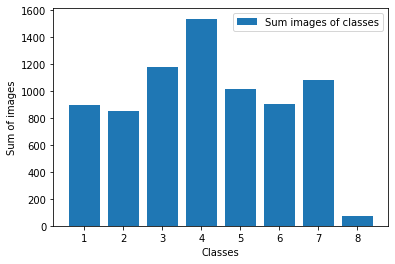

In [43]:
Plots.plot_amount_samples("data/processed", label_num=True)

In [46]:
classes = ["brak_wielowypustu", "niezahartowane", "brak_kanalka", "srodek_nieobrobiony"]

label_mapping = {
      "1": [1, 0, 1, 0],
      "2": [1, 1, 1, 0],
      "3": [0, 1, 1, 0],
      "4": [0, 0, 0, 0],
      "5": [0, 0, 1, 0],
      "6": [0, 0, 0, 1],
      "7": [0, 0, 1, 1],
      "8": [1, 0, 1, 1],
  }

X, y = [], []

files = get_files('data/processed')

with tqdm(total=len(files)) as pbar:
  for path in files:
    img = load_img(path, target_size=(128, 128, 3))
    img = img_to_array(img)
    img = img/255.0

    X.append(img)
    y.append(label_mapping[path.split("/")[2]])

    pbar.update(1)

X = np.array(X)
y = np.array(y)
print(f"X shape: {X.shape}, y shape: {y.shape}")

100%|██████████| 7548/7548 [00:32<00:00, 234.85it/s]


X shape: (7548, 128, 128, 3), y shape: (7548, 4)


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, shuffle=True)

In [48]:
model = Sequential([
        InputLayer(input_shape=(128, 128, 3)),

        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPool2D(pool_size=(2, 2)),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPool2D(pool_size=(2, 2)),

        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPool2D(pool_size=(2, 2)),

        GlobalAveragePooling2D(),

        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),

        Dense(4, activation='sigmoid'),
    ])

model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.BinaryAccuracy(threshold=.5)])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 256)      0

In [49]:
dt = datetime.now().strftime('%d_%m_%Y_%H_%M')
filepath = os.path.join('output', 'model_' + dt + '.hdf5')
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_binary_accuracy', save_best_only=True)

In [50]:
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=4, epochs=100, callbacks=[checkpoint, tensorboard_callback])

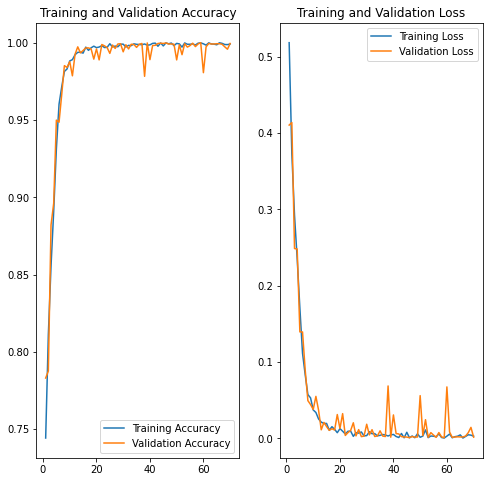

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(70)
epochs_range = list(map(lambda x: x + 1, epochs_range))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Load Model

In [ ]:
import pickle
print('output/model_'+dt+'.hdf5')
model = load_model('output/model_'+dt+'.hdf5')

output/model_12_01_2023_14_18.hdf5


In [ ]:
def predict(path, model):
  img = load_img(path, target_size=(128, 128, 3))
  img = img_to_array(img)
  nativ, img = img, img/255.0

  img = np.expand_dims(img, axis=0)

  y_pred = model.predict(img)

  prop = y_pred

  y_pred = np.argsort(y_pred[0])

  for i in range(4):
    print(f"Class: { classes[y_pred[i]] }, prob: { round(prop[0][y_pred[i]] * 100, 2) }%") 

  nativ = cv2.resize(nativ, (244, 244), interpolation = cv2.INTER_AREA)
  cv2_imshow(nativ)

for dir in [str(i+1) for i in range(7)]:
  files = os.listdir(f"data/raw/" + dir)
  rng = random.randint(0, len(files))
  image = files[rng]
  predict(f'data/raw/{dir}/{image}', model)
  print(f'data/raw/{dir}/{image}')